# Import Necessary Packages and Libraries

In [1]:
# IMAGE PREPROCESSING FUNCTIONS FOR USE IN MODEL DEVELOPMENT, EVALUATION, AND PRODUCTION
import numpy as np
import pandas as pd
import PIL as pil
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import tempfile
import pickle
import time
import gc
import skimage.filters
import cv2
import watermark
import joblib
import math
from skimage.measure import block_reduce
from image_preprocessing import standardize_image_dataset,resize_dataset,binarize_dataset,crop_dataset,process_dataset_blur,do_pooling_dataset
from pipeline import model_pipeline
from automate_optimal_model_dev import automate_optimal_model_dev
from eval_on_test import make_preds

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB,CategoricalNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.base import clone
from sklearn.metrics import confusion_matrix

# Read in Training Data

In [2]:
all_data = pickle.load(open('Amit/Labeled Data/train_data.pkl','rb'))
x = all_data.iloc[:,:-1]
y = all_data.iloc[:,-1]

# Develop Optimal Logistic Regression Model using Optimal Preprocessing Steps as identified by Arindam's Run

- preprocessing includes resizing to initial size (256,256), and a maxpool with 2x2 filter size
- C value = inverse weight of L2 regularization = 0.0001, 1000 maximum iterations for gradient descent for developing optimal hyperplane to separate classes in feature space

In [3]:
%%time

logreg_model = model_pipeline().evaluate(resize_dataset(x,(256,256),(256,256)),y,preprocessing = [('pool',[(2,2),np.max])],
                                        model=LogisticRegression(),param_grid = {'C':[0.0001],'max_iter':[1000]},
                                        optimizing_metric='f1',n_splits=5)

CPU times: user 27min 46s, sys: 14min 18s, total: 42min 5s
Wall time: 6min 44s


In [4]:
logreg_model.pop('features')

0      1      2      3      4      5      6      7      8      9      \
54        0      0      0      0      0      0      0    255    255    255   
2602      0      0      0      0      0      0      0      0      0      0   
3433      0      0      0      0      0      0      0      0      0      0   
235       6      6      6      6      6      6      6      6      6      6   
1806      0      0      0      0      0      0      0      0     59     63   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3330      0      0      0      0      0      0      0      0      0      0   
70        0      0      0      0      0      0      0      0      0     72   
132       0      0      0      0      0      0      0      0      0      0   
2014      0      0      0      0      0      0      0      0      0      0   
1931      0      0      0      0      0      0      0      0      0      0   

      ...  16374  16375  16376  16377  16378  16379  16380  16381  16382  \
54    ...    255    255    252      0      0      0      0      0      0   
2602  ...      0      0      0      0      0      0      0      0      0   
3433  ...      0      0      0      0      0      0      0      0      0   
235   ...      7      7      7      7      7      7      7      7      6   
1806  ...     44     36      0      0      0      0      0      0      0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3330  ...      0      0      0      0      0      0      0      0      0   
70    ...      0      0      0      0      0      0      0      0      0   
132   ...      0      0      0      0      0      0      0      0      0   
2014  ...      1      1      1      1      1      1      1      1      0   
1931  ...      0      0      0      0      0      0      0      0      0   

      16383  
54        0  
2602      0  
3433      0  
235       6  
1806      0  
...     ...  
3330      0  
70        0  
132       0  
2014      0  
1931      0  

[3220 rows x 16384 columns]

In [5]:
pickle.dump(logreg_model,open('Linear Model Results/logistic_regression.pkl','wb'))

In [6]:
test_data = pickle.load(open('Amit/Labeled Data/training_data.pkl','rb'))
y = test_data['label']
x = test_data.iloc[:,:-1]


In [7]:
log_reg = pickle.load(open('Linear Model Results/logistic_regression.pkl','rb'))


In [8]:
%%time

logreg_preds = make_preds(do_pooling_dataset(resize_dataset(x,(256,256),(256,256)),(2,2),np.max).astype('uint8'),y,[],
                          log_reg['best_estimator'],log_reg['threshold_analysis']['best_thresh'],return_features=True)


CPU times: user 1min 40s, sys: 2.25 s, total: 1min 42s
Wall time: 1min 42s


In [9]:
logreg_preds["accuracy"]


0.9471014492753623

In [10]:
logreg_preds["confusion_matrix"]

array([[596,  50],
       [ 23, 711]])

In [11]:
logreg_preds["f1 score"]

0.951170568561873

In [12]:
logreg_preds['probs']

array([0.01282272, 0.98005692, 0.25852198, ..., 0.99970968, 0.92381611,
       0.00363372])

In [13]:
logreg_preds

{'features':       0      1      2      3      4      5      6      7      8      9      \
 3949      0      0      0      0      0      0      0      0      0      0   
 230       0      0      0      0      0      0      0      0      0      0   
 354       0      0      0      0      0      4      5      8      9      7   
 2736      0      0      0      0      0      0      0      0      0      0   
 3540      0      0      0      2      2      2      2      2      2      2   
 ...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
 1776      0      0      0      0      0      0      0      0      0      0   
 1791      0      0      0      0      0      0      0      0      0      0   
 2099      0      0      0      0      0      0      0      0      0      0   
 53        0      0      0      0      0      0      0      0      0      0   
 3857      0      0      0      0      0      0      0      0      0     14   
 
       ...  16374  16375  16376  16377

In [14]:
y

3949    0
230     1
354     1
2736    0
3540    0
       ..
1776    1
1791    1
2099    1
53      1
3857    0
Name: label, Length: 1380, dtype: uint8

In [17]:
misclassified_images = x[logreg_preds['preds'] != y]
correct_classified_images = x[logreg_preds['preds'] == y]
misclassified_preprocessed_images = logreg_preds['features'][logreg_preds['preds'] != y]
correct_classified_preprocessed_images = logreg_preds['features'][logreg_preds['preds'] == y]
misclassified_labels = y[logreg_preds['preds'] != y]
correct_classified_labels = y[logreg_preds['preds'] == y]
misclassified_probabilities = logreg_preds['probs'][logreg_preds['preds'] != y]
correct_classified_probabilities = logreg_preds['probs'][logreg_preds['preds'] == y]




In [28]:
correct_classified_images.iloc[0]


pixel1        0
pixel2        0
pixel3        0
pixel4        0
pixel5        0
             ..
pixel65532    0
pixel65533    0
pixel65534    0
pixel65535    0
pixel65536    0
Name: 3949, Length: 65536, dtype: uint8

In [21]:
correct_classified_preprocessed_images


0      1      2      3      4      5      6      7      8      9      \
3949      0      0      0      0      0      0      0      0      0      0   
230       0      0      0      0      0      0      0      0      0      0   
354       0      0      0      0      0      4      5      8      9      7   
2736      0      0      0      0      0      0      0      0      0      0   
3540      0      0      0      2      2      2      2      2      2      2   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1776      0      0      0      0      0      0      0      0      0      0   
1791      0      0      0      0      0      0      0      0      0      0   
2099      0      0      0      0      0      0      0      0      0      0   
53        0      0      0      0      0      0      0      0      0      0   
3857      0      0      0      0      0      0      0      0      0     14   

      ...  16374  16375  16376  16377  16378  16379  16380  16381  16382  \
3949  ...      0      0      0      0      0      0      0      0      0   
230   ...      0      0      0      0      0      0      0      0      0   
354   ...      8      8      8      5      1      0      0      0      0   
2736  ...      0      0      0      0      0      0      0      0      0   
3540  ...      2      2      2      2      2      2      0      0      0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1776  ...     15     15     16     12     12     12     13     10      7   
1791  ...      0      0      0      0      0      0      0      0      0   
2099  ...      0      0      0      0      0      0      0      0      0   
53    ...      0      0      0      0      0      0      0      0      0   
3857  ...      2      0      0      0      0      0      0      0      0   

      16383  
3949      0  
230       0  
354       0  
2736      0  
3540      0  
...     ...  
1776      6  
1791      0  
2099      0  
53        0  
3857      0  

[1307 rows x 16384 columns]

In [22]:
correct_classified_labels


3949    0
230     1
354     1
2736    0
3540    0
       ..
1776    1
1791    1
2099    1
53      1
3857    0
Name: label, Length: 1307, dtype: uint8

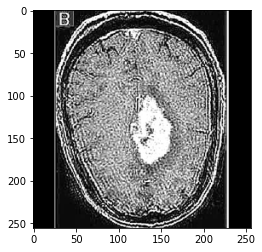

In [33]:
plt.imshow(np.array(correct_classified_images.iloc[1]).reshape(256,256),cmap='gray')

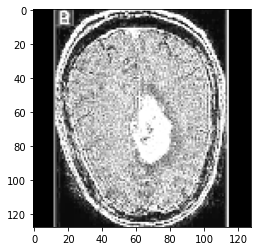

In [34]:
plt.imshow(np.array(correct_classified_preprocessed_images.iloc[1]).reshape(128,128),cmap='gray')


In [36]:
correct_classified_probabilities[1]

0.9800569221604121

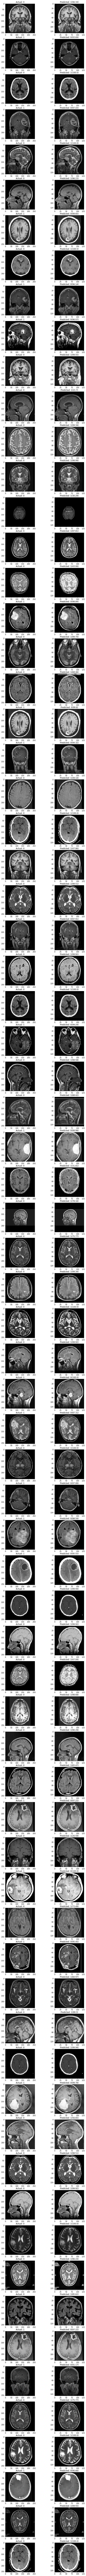

In [16]:
fig,axes = plt.subplots(nrows=len(misclassified_images),ncols=2,figsize=(10,int(len(misclassified_images)*4)))
for num in range(len(misclassified_images)):
    axes[num][0].imshow(np.array(misclassified_images.iloc[num]).reshape(256,256),cmap='gray')
    axes[num][1].imshow(np.array(misclassified_preprocessed_images.iloc[num]).reshape(int(np.sqrt(misclassified_preprocessed_images.shape[1])),
                                                                                      int(np.sqrt(misclassified_preprocessed_images.shape[1]))),cmap='gray')
    axes[num][0].set_title('Actual: ' + str(misclassified_labels.iloc[num]))
    if misclassified_labels.iloc[num] == 0:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels.iloc[num] - 1)) + '(' + str(round(100*misclassified_probabilities[num],2)) + ')')
    else:
        axes[num][1].set_title('Predicted: ' + str(abs(misclassified_labels.iloc[num] - 1)) + '(' + str(round(100 - 100*misclassified_probabilities[num],2)) + ')')

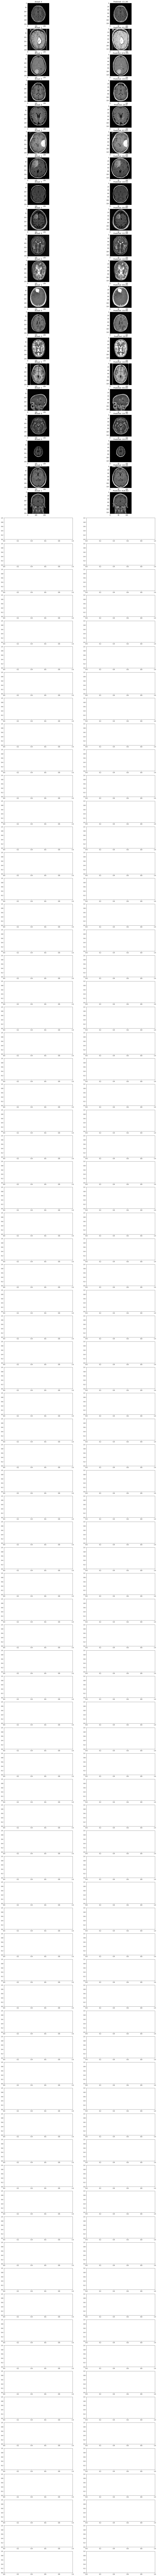

In [47]:
fig,axes = plt.subplots(nrows=100,ncols=2,figsize=(20,350))
# for num in range(len(correct_classified_images)):
for num in range(20):
    axes[num][0].imshow(np.array(correct_classified_images.iloc[num]).reshape(256,256),cmap='gray')
    axes[num][1].imshow(np.array(correct_classified_preprocessed_images.iloc[num]).reshape(128, 128),cmap='gray')
    axes[num][0].set_title('Actual: ' + str(correct_classified_labels.iloc[num]))
    if correct_classified_labels.iloc[num] == 0:
        axes[num][1].set_title('Predicted: ' + str(abs(correct_classified_labels.iloc[num] - 1)) + '(' + str(round(100*correct_classified_probabilities[num],2)) + ')')
    else:
        axes[num][1].set_title('Predicted: ' + str(abs(correct_classified_labels.iloc[num] - 1)) + '(' + str(round(100 - 100*correct_classified_probabilities[num],2)) + ')')